## Task 1 — Surface ship surge: GAS vs GES vs unstable

We study a scalar surge-speed error dynamics with equilibrium at the desired reference $u_{\mathrm{ref}}$.

- $h(u) = -X_u u - X_{uu}\,u|u|$

and a shifted function

- $g(u)=h(u)-h(u_{\mathrm{ref}})$, so that $g(u_{\mathrm{ref}})=0$.

This makes $u=u_{\mathrm{ref}}$ an equilibrium for all three closed-loop models below.

### The three closed-loop models

- **GAS (non-exponential)**: $\dot u = -(u-u_{\mathrm{ref}})\,g(u) - g(u)^2$.

  This is a nonlinear stabilizing law shaped by the monotone damping term; trajectories converge to $u_{\mathrm{ref}}$ in a globally asymptotic (but generally non-exponential) way.

- **GES (exponential)**: $\dot u = -k(u-u_{\mathrm{ref}})$, which has the closed-form solution
  $u(t)=u_{\mathrm{ref}}+(u_0-u_{\mathrm{ref}})e^{-kt}$ (exponential convergence).

- **Unstable**: $\dot u = +(u-u_{\mathrm{ref}})$, giving
  $u(t)=u_{\mathrm{ref}}+(u_0-u_{\mathrm{ref}})e^{t}$ (exponential divergence).

The plots in the code cell above show how different initial conditions $u(0)=u_0$ evolve relative to the reference line $u_{\mathrm{ref}}$.


Closed-form solution (GES):


<IPython.core.display.Math object>


Closed-form solution (Unstable):


<IPython.core.display.Math object>

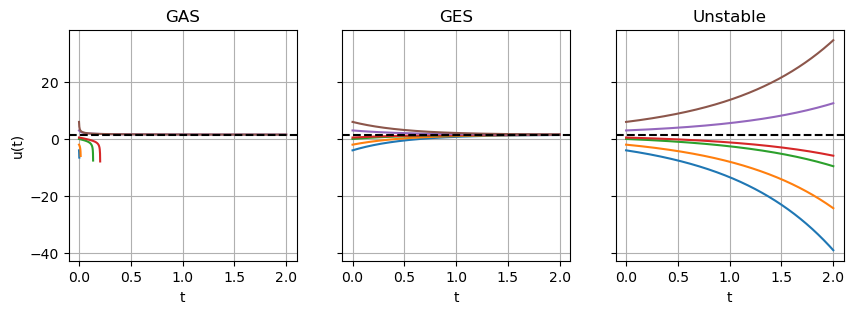

In [1]:
# Task 1 - Surface ship surge model

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from IPython.display import display, Math
from scipy.integrate import solve_ivp

def show(expr):
    display(Math(sp.latex(expr)))

# Physical parameters (consistent but arbitrary)

M = 5.0          # Effective mass
Xu = 1.0         # Linear damping
Xuu = 1.0        # Quadratic damping

u_ref = 1.5      # Reference surge speed

# Nonlinear ship damping h(u)
# h(u)u > 0, monotone, h(0)=0

def h(u):
    return -Xu*u - Xuu*u*np.abs(u)

# Shifted function g(u) = h(u) - h(u_ref)
def g(u):
    return h(u) - h(u_ref)

# Closed-loop systems

# GAS (non-exponential)
def f_GAS(t, u):
    return -(u - u_ref)*g(u) - g(u)**2

# GES (exponential)
k = 2.0
def f_GES(t, u):
    return -k*(u - u_ref)

# Unstable
def f_UNSTABLE(t, u):
    return +(u - u_ref)

# Symbolic closed-form solutions (linear cases)
t = sp.symbols('t', real=True)
u0_sym, uref_sym, k_sym = sp.symbols('u_0 u_ref k', real=True)
u_t = sp.Function('u')(t)

sol_ges = sp.Eq(u_t, uref_sym + (u0_sym - uref_sym) * sp.exp(-k_sym * t))
sol_unstable = sp.Eq(u_t, uref_sym + (u0_sym - uref_sym) * sp.exp(t))

print("\nClosed-form solution (GES):")
show(sol_ges)
print("\nClosed-form solution (Unstable):")
show(sol_unstable)

# Simulation setup

# Separate time grids for better resolution
t_eval_10 = np.linspace(0, 2, 1500)
t_eval_6  = np.linspace(0, 2, 1500)

initial_conditions = [
    -4.0,
    -2.0,
    0.0,
    0.5,
    3.0,
    6.0
]

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

systems = [
    (f_GAS, "GAS", [0, 10], t_eval_10),
    (f_GES, "GES", [0, 10], t_eval_10),
    (f_UNSTABLE, "Unstable", [0, 6], t_eval_6)
]

for ax, (f_sys, title, tspan, teval) in zip(axs, systems):
    for u0 in initial_conditions:
        sol = solve_ivp(f_sys, tspan, [u0], t_eval=teval)
        ax.plot(sol.t, sol.y[0])
    ax.axhline(u_ref, color="k", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("t")
    ax.grid()

axs[0].set_ylabel("u(t)")
plt.show()

## Task 2 — Pendulum with fan control (energy/Lyapunov intuition)

We model a pendulum state $x = [\theta,\ \omega]^\top$ with a horizontal fan force input $u$ (Newtons). The dynamics used in the next cell are:

- $\dot\theta = \omega$

- $\dot\omega = -\frac{g}{l}\sin\theta\; -\;\frac{k}{m l^2}\,\omega\; +\; \frac{u}{m l}\cos\theta$

A natural Lyapunov candidate for the **unforced** case ($u=0$) is the total mechanical energy:

- $V(\theta,\omega)= m g l\,(1-\cos\theta) + \tfrac{1}{2} m l^2\,\omega^2$

With viscous friction, the energy decreases along trajectories when $u=0$: $\dot V = -k\,\omega^2 \le 0$.

- **No fan** ($u=0$): trajectories lose energy and settle (due to friction).

- **Constant fan** ($u=\text{const}$): the input shifts the behavior and can (for a suitable value) help bias the motion toward a desired operating region.


Symbolic V(theta, omega):


<IPython.core.display.Math object>


Symbolic Vdot (general u):


<IPython.core.display.Math object>


Symbolic Vdot for u = 0:


<IPython.core.display.Math object>

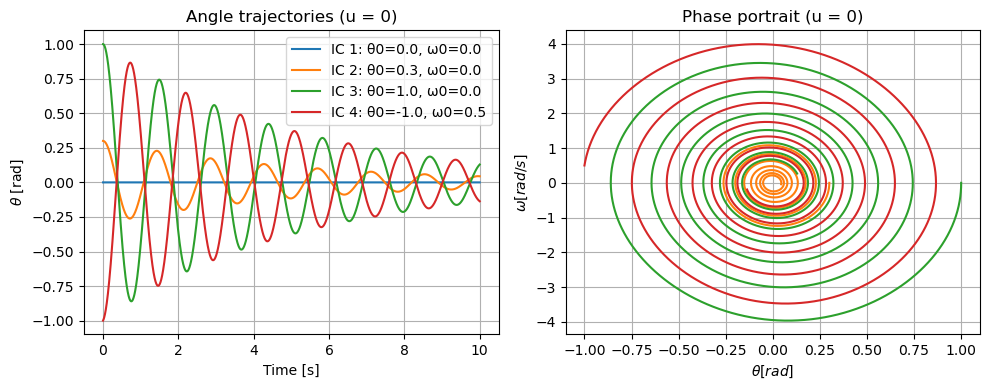

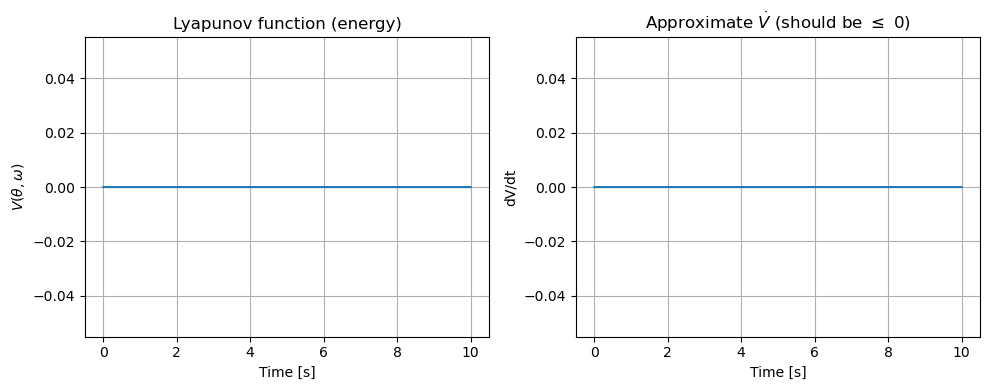

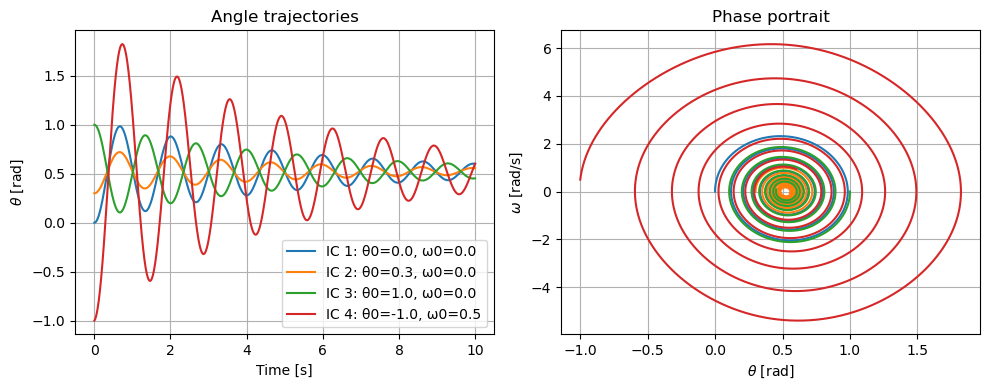

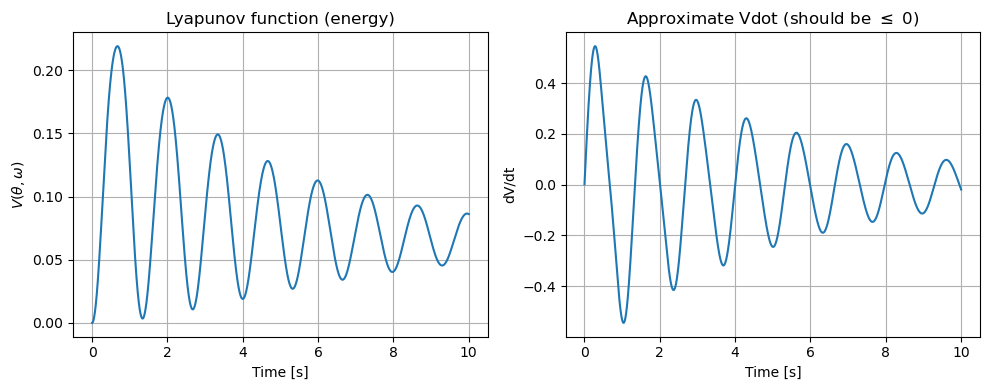

In [2]:
# Task 2 - Pendulum with fan control

import sympy as sp
from IPython.display import display, Math

def show(expr):
    display(Math(sp.latex(expr)))

# Parameters
m = 0.1       # kg
l = 0.5       # m
g = 9.81      # m/s^2
k = 0.01      # friction coefficient

# Symbolic energy / Lyapunov derivative (for display)
theta_s, omega_s, u_s = sp.symbols('theta omega u', real=True)
m_s, l_s, g_s, k_s = sp.symbols('m l g k', positive=True, real=True)

V_s = m_s*g_s*l_s*(1 - sp.cos(theta_s)) + sp.Rational(1, 2)*m_s*l_s**2*omega_s**2
dtheta_s = omega_s
domega_s = -(g_s/l_s)*sp.sin(theta_s) - (k_s/(m_s*l_s**2))*omega_s + (u_s/(m_s*l_s))*sp.cos(theta_s)
Vdot_s = sp.simplify(sp.diff(V_s, theta_s)*dtheta_s + sp.diff(V_s, omega_s)*domega_s)

print("\nSymbolic V(theta, omega):")
show(V_s)
print("\nSymbolic Vdot (general u):")
show(Vdot_s)
print("\nSymbolic Vdot for u = 0:")
show(sp.simplify(Vdot_s.subs(u_s, 0)))

# Nonlinear dynamics: x_dot = f(x, u), where x = [theta, omega]^T and u = F_fan
def f(x, u):
    theta, omega = x

    dtheta = omega
    domega = (
        - (g / l) * np.sin(theta)
        - (k / (m * l**2)) * omega
        + (u / (m * l)) * np.cos(theta)
    )
    return np.array([dtheta, domega])

# Lyapunov function (mechanical energy) for u = 0
def V_energy(theta, omega):
    V_p = m * g * l * (1 - np.cos(theta))
    V_k = 0.5 * m * l**2 * omega**2
    return V_p + V_k

def V_dot(omega):
    return - k * omega**2

# Simulation setup
dt = 0.001          # time step [s]
T  = 10.0           # total time [s]
N  = int(T / dt)
time = np.linspace(0, T, N)

# Control input (here: no fan force)
def fan_force(t, force):
    return force

# Different initial conditions to illustrate convergence
initial_conditions = [
    (0.0, 0.0),
    (0.3, 0.0),
    (1.0, 0.0),
    (-1.0, 0.5)
]

# Storage for plotting one representative trajectory's energy
theta_ref = None
omega_ref = None
V_ref = None

# Simulate for each initial condition
plt.figure(figsize=(10, 4))

# Angle vs time
plt.subplot(1, 2, 1)
for idx, (theta0, omega0) in enumerate(initial_conditions):
    x = np.zeros((2, N))
    x[:, 0] = [theta0, omega0]
    force = 0.0  # No fan force

    for i in range(N - 1):
        u = fan_force(time[i], force)
        x[:, i + 1] = x[:, i] + dt * f(x[:, i], u)

    theta = x[0, :]
    omega = x[1, :]

    plt.plot(time, theta, label=f"IC {idx+1}: θ0={theta0}, ω0={omega0}")

    # Store reference trajectory for energy plot (first IC)
    if idx == 0:
        theta_ref = theta
        omega_ref = omega

plt.xlabel("Time [s]")
plt.ylabel(r"$\theta$ [rad]")
plt.title("Angle trajectories (u = 0)")
plt.legend()
plt.grid()

# Phase portrait
plt.subplot(1, 2, 2)
for (theta0, omega0) in initial_conditions:
    x = np.zeros((2, N))
    x[:, 0] = [theta0, omega0]
    force = 0.0  # No fan force

    for i in range(N - 1):
        u = fan_force(time[i], force)
        x[:, i + 1] = x[:, i] + dt * f(x[:, i], u)

    theta = x[0, :]
    omega = x[1, :]
    plt.plot(theta, omega)

plt.xlabel(r"$\theta [rad]$")
plt.ylabel(r"$\omega [rad/s]$")
plt.title("Phase portrait (u = 0)")
plt.grid()

plt.tight_layout()
plt.show()

# Energy (Lyapunov) along one trajectory
V_ref = V_energy(theta_ref, omega_ref)
Vdot_num = np.gradient(V_ref, dt)
Vdot_analytical = V_dot(omega_ref)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(time, V_ref)
plt.xlabel("Time [s]")
plt.ylabel(r"$V(\theta, \omega)$")
plt.title("Lyapunov function (energy)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, Vdot_num)
plt.xlabel("Time [s]")
plt.ylabel("dV/dt")
plt.title(r"Approximate $\dot{V}$ (should be $\leq$ 0)")
plt.grid()

plt.tight_layout()
plt.show()

# Simulate for each initial condition (constant fan force)
plt.figure(figsize=(10, 4))

# Angle vs time
plt.subplot(1, 2, 1)
for idx, (theta0, omega0) in enumerate(initial_conditions):
    x = np.zeros((2, N))
    x[:, 0] = [theta0, omega0]
    force = 0.56638  # Constant fan force to stabilize

    for i in range(N - 1):
        u = fan_force(time[i], force)
        x[:, i + 1] = x[:, i] + dt * f(x[:, i], u)

    theta = x[0, :]
    omega = x[1, :]

    plt.plot(time, theta, label=f"IC {idx+1}: θ0={theta0}, ω0={omega0}")

    # Store reference trajectory for energy plot (first IC)
    if idx == 0:
        theta_ref = theta
        omega_ref = omega

plt.xlabel("Time [s]")
plt.ylabel(r"$\theta$ [rad]")
plt.title("Angle trajectories")
plt.legend()
plt.grid()

# Phase portrait
plt.subplot(1, 2, 2)
for (theta0, omega0) in initial_conditions:
    x = np.zeros((2, N))
    x[:, 0] = [theta0, omega0]
    force = 0.56638  # Constant fan force to stabilize

    for i in range(N - 1):
        u = fan_force(time[i], force)
        x[:, i + 1] = x[:, i] + dt * f(x[:, i], u)

    theta = x[0, :]
    omega = x[1, :]
    plt.plot(theta, omega)

plt.xlabel(r"$\theta$ [rad]")
plt.ylabel(r"$\omega$ [rad/s]")
plt.title("Phase portrait")
plt.grid()

plt.tight_layout()
plt.show()

# Energy (Lyapunov) along one trajectory
V_ref = V_energy(theta_ref, omega_ref)
Vdot_num = np.gradient(V_ref, dt)
Vdot_analytical = V_dot(omega_ref)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(time, V_ref)
plt.xlabel("Time [s]")
plt.ylabel(r"$V(\theta, \omega)$")
plt.title("Lyapunov function (energy)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, Vdot_num)
plt.xlabel("Time [s]")
plt.ylabel("dV/dt")
plt.title(r"Approximate Vdot (should be $\leq$ 0)")
plt.grid()

plt.tight_layout()
plt.show()

## Task 3 — Quadratic Lyapunov function in matrix form

This part builds a standard quadratic Lyapunov function for a 2D state $x=[x_1,\ x_2]^\top$:

- $V(x) = c_1 x_1^2 + c_2 x_1 x_2 + c_3 x_2^2$


A key rewriting is $V(x)=x^\top P x$ with

- $P = \begin{bmatrix} c_1 & c_2/2 \\ c_2/2 & c_3 \end{bmatrix}$


**Positive definiteness** (so $V$ is a proper Lyapunov function) is guaranteed by conditions like:

- $c_1>0$, $c_3>0$, and $\det(P)=c_1 c_3 - (c_2^2)/4 > 0$


For the simple integrator dynamics $\dot x = u$, differentiation gives:

- $\dot V = \nabla V(x)^\top u = 2 x^\top P u$


For a linear closed-loop $\dot x = A x$, we get:

- $\dot V = x^\top (P A + A^\top P) x = -x^\top Q x$ where $Q := -(P A + A^\top P)$

So if $Q\succ 0$, then $\dot V < 0$ for all $x\neq 0$ (global asymptotic stability).


Vdot (general):


<IPython.core.display.Math object>


Matrix P:


<IPython.core.display.Math object>


Check V = x^T P x:


<IPython.core.display.Math object>


det(P) =


<IPython.core.display.Math object>


Vdot from vector differentiation:


<IPython.core.display.Math object>


Difference (should be zero):


<IPython.core.display.Math object>


Closed-loop matrix A:


<IPython.core.display.Math object>


General Q = -(PA + A^T P):


<IPython.core.display.Math object>


Chosen P:


<IPython.core.display.Math object>


Resulting Q:


<IPython.core.display.Math object>


Vdot along closed-loop:


<IPython.core.display.Math object>

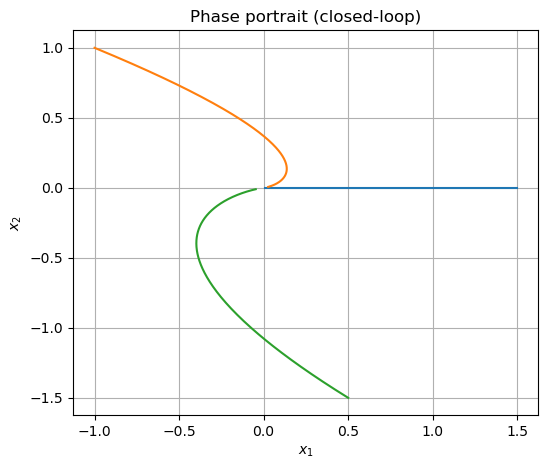

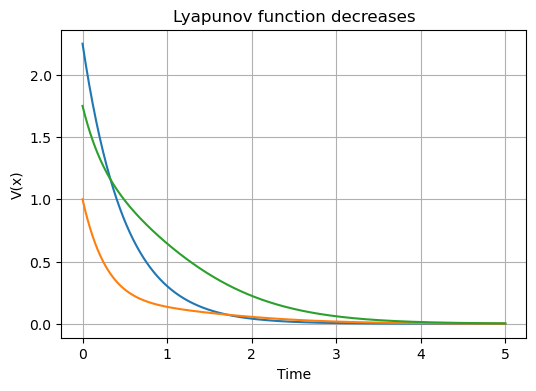

In [3]:
# Task 3 - Lyapunov function and equation

import sympy as sp
from IPython.display import display, Math

def show(expr):
    display(Math(sp.latex(expr)))

x1, x2 = sp.symbols('x1 x2', real=True)
u1, u2 = sp.symbols('u1 u2', real=True)

c1, c2, c3 = sp.symbols('c1 c2 c3', positive=True)

x = sp.Matrix([x1, x2])
u = sp.Matrix([u1, u2])

# Lyapunov function
V = c1*x1**2 + c2*x1*x2 + c3*x2**2

# Differentiate along xdot = u
Vdot_general = sp.diff(V, x1)*u1 + sp.diff(V, x2)*u2
print("\nVdot (general):")
show(Vdot_general)

# Matrix form V = x^T P x
P = sp.Matrix([
    [c1, c2/2],
    [c2/2, c3]
])

print("\nMatrix P:")
show(P)

print("\nCheck V = x^T P x:")
show(sp.simplify((x.T*P*x)[0]))

# Positive definiteness of P
detP = P.det()
print("\ndet(P) =")
show(detP)

# Conditions:
# c1 > 0
# c3 > 0
# c1*c3 - (c2^2)/4 > 0

# Vector differentiation
Vdot_vector = 2*(x.T*P*u)[0]

print("\nVdot from vector differentiation:")
show(Vdot_vector)

print("\nDifference (should be zero):")
show(sp.simplify(Vdot_vector - Vdot_general))

# Closed-loop system
A = sp.Matrix([
    [-1,  1],
    [ 0, -1]
])

print("\nClosed-loop matrix A:")
show(A)

Q_expr = -(P*A + A.T*P)

print("\nGeneral Q = -(PA + A^T P):")
show(Q_expr)

# Choose coefficients as in solution
P_num = sp.Matrix([
    [1, sp.Rational(1,2)],
    [sp.Rational(1,2), 1]
])

Q_num = -(P_num*A + A.T*P_num)

print("\nChosen P:")
show(P_num)

print("\nResulting Q:")
show(Q_num)

# Lyapunov derivative for the closed-loop
Vdot_closed = (x.T*(P_num*A + A.T*P_num)*x)[0]

print("\nVdot along closed-loop:")
show(sp.factor(Vdot_closed))

# Numerical simulation
A_num = np.array(A, dtype=float)
P_num_np = np.array(P_num, dtype=float)

def f_cl(x):
    return A_num @ x

dt = 0.01
T = 5.0
N = int(T/dt)
time = np.linspace(0, T, N)

initial_conditions = [
    np.array([1.5, 0.0]),
    np.array([-1.0, 1.0]),
    np.array([0.5, -1.5])
]

# Phase portrait
plt.figure(figsize=(6,5))

for x0 in initial_conditions:
    xtraj = np.zeros((2, N))
    xtraj[:,0] = x0

    for k in range(N-1):
        xtraj[:,k+1] = xtraj[:,k] + dt*f_cl(xtraj[:,k])

    plt.plot(xtraj[0], xtraj[1])

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Phase portrait (closed-loop)")
plt.grid()
plt.show()

# Lyapunov function vs time
plt.figure(figsize=(6,4))

for x0 in initial_conditions:
    xtraj = np.zeros((2, N))
    xtraj[:,0] = x0

    for k in range(N-1):
        xtraj[:,k+1] = xtraj[:,k] + dt*f_cl(xtraj[:,k])

    Vtraj = np.einsum('ij,ji->i', xtraj.T @ P_num_np, xtraj)
    plt.plot(time, Vtraj)

plt.xlabel("Time")
plt.ylabel("V(x)")
plt.title("Lyapunov function decreases")
plt.grid()
plt.show()

## Lyapunov geometry intuition (level sets)

Here we visualize how trajectories move relative to the level sets of a simple candidate $V(x)=x_1^2+x_2^2$.


The nonlinear system used in the next cell is:

- $\dot x_1 = x_2$

- $\dot x_2 = -x_1 - x_2^3$


The contour plot shows the sets $\{x : V(x)=\text{const}\}$ (circles). Overlaying trajectories helps build intuition: if $V$ tends to decrease along trajectories, the paths cut inward across level sets toward the origin. Even when $V$ is only a *candidate*, this picture is a useful geometric diagnostic.

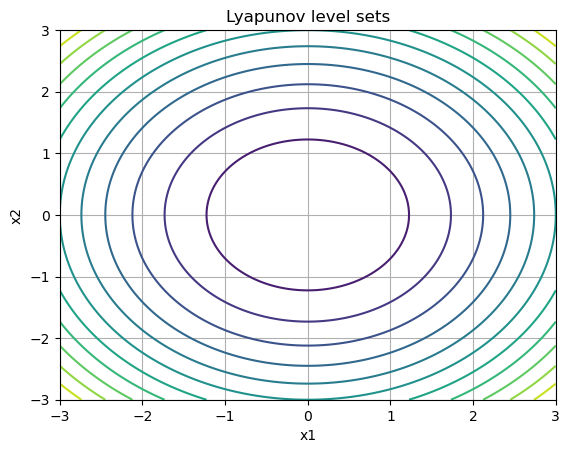

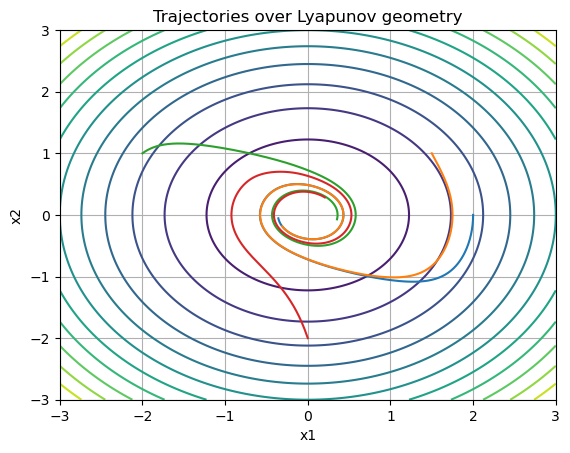

In [4]:
# System definition
def f(t, X):
    x1, x2 = X
    dx1 = x2
    dx2 = -x1 - x2**3
    return [dx1, dx2]

# Lyapunov candidate (geometry only)
def V(x1, x2):
    return x1**2 + x2**2

# Level sets
x1 = np.linspace(-3, 3, 200)
x2 = np.linspace(-3, 3, 200)
X1, X2 = np.meshgrid(x1, x2)
Z = V(X1, X2)

plt.contour(X1, X2, Z, levels=12)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Lyapunov level sets")
plt.grid()
plt.show()

# Trajectories over level sets
initial_conditions = [
    [2, 0],
    [1.5, 1],
    [-2, 1],
    [0, -2]
]

t_eval = np.linspace(0, 10, 1000)

plt.figure()
plt.contour(X1, X2, Z, levels=12)

for x0 in initial_conditions:
    sol = solve_ivp(f, [0, 10], x0, t_eval=t_eval)
    plt.plot(sol.y[0], sol.y[1])

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Trajectories over Lyapunov geometry")
plt.grid()
plt.show()

## Saturation nonlinearity (control-style primitive)

The last cell plots the saturation function, commonly used to model actuator limits:

$\operatorname{sat}(x)=\begin{cases}-1,&x<-1\\x,&|x|\le 1\\1,&x>1\end{cases}$


It behaves like a linear gain near the origin but "clips" for large magnitude inputs, which is why it's a standard building block in nonlinear/robust control examples.

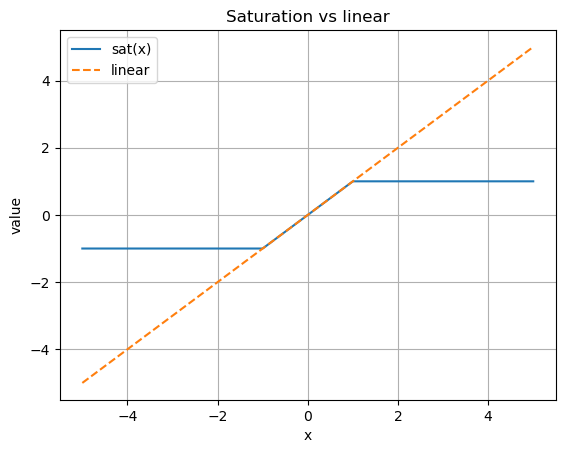

In [5]:
x = np.linspace(-5, 5, 400)

def sat(x):
    return np.clip(x, -1, 1)

plt.plot(x, sat(x), label="sat(x)")
plt.plot(x, x, "--", label="linear")
plt.xlabel("x")
plt.ylabel("value")
plt.title("Saturation vs linear")
plt.legend()
plt.grid()
plt.show()